# Project 6: Develop an automatic classification engine for consumer goods.
*Pierre-eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.



In [1]:
# Import usual libraries
import numpy as np
import pandas as pd
import os
import time

# to make this notebook's output stable across runs
np.random.seed(89)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'axes.titleweight': 'bold',
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Natural-Language-Processing-(NLP)" data-toc-modified-id="Natural-Language-Processing-(NLP)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Natural Language Processing (NLP)</a></span><ul class="toc-item"><li><span><a href="#Text-preprocessing" data-toc-modified-id="Text-preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Text preprocessing</a></span><ul class="toc-item"><li><span><a href="#Lower-casing" data-toc-modified-id="Lower-casing-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Lower casing</a></span></li><li><span><a href="#Tokenization" data-toc-modified-id="Tokenization-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Tokenization</a></span></li><li><span><a href="#Stop-words-removal" data-toc-modified-id="Stop-words-removal-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Stop words removal</a></span></li><li><span><a href="#Lemmatization" data-toc-modified-id="Lemmatization-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Lemmatization</a></span></li></ul></li><li><span><a href="#Feature-extraction" data-toc-modified-id="Feature-extraction-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Feature extraction</a></span><ul class="toc-item"><li><span><a href="#Bag-of-words" data-toc-modified-id="Bag-of-words-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Bag of words</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li></ul></li></ul></div>

# Get data

In [2]:
data = (pd.read_csv("data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")
          .set_index('uniq_id'))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7 to f2f027ad6a6df617c9f125173da71e44
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crawl_timestamp          1050 non-null   object 
 1   product_url              1050 non-null   object 
 2   product_name             1050 non-null   object 
 3   product_category_tree    1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    712 non-null    object 
 13  product_specifications  

The most promising attribute to automate the goods classification is the *description* feature, gathering text data. The problem with modeling text is that it is *messy*, while machine learning algorithms prefer well defined fixed-length inputs and outputs. Therefore, these algorithms cannot learn from the raw text directly, the latter must be previously converted into vectors of numbers. Let's see how it can be carried out.

## Natural Language Processing (NLP)

As previously said, before using any Machine Learning on text, the latter must be transformed into something an algorithm can digest: vectors of numbers. This process is called Natural Language Processing (NLP) and includes two sequential steps:
1. Text Preprocessing
2. Feature extraction

The first one provides a clean and normalize dataset, while the second one converts the prepared text to a vector of numbers.

### Text preprocessing

Text preprocessing, or data nomalization, is a process of converting data from the initial raw form into a format more suitable for further analysis.
Since data are text and not numbers, we will not use the same techniques that for a classic data wrangling.  
The most common ones used to prepare text data are listed below:
- Lower casing &ndash; convert a word to lower case;
- Tokenization &ndash; convert sentences to words;
- Remove unnecessary punctuation, numbers;
- Remove **stop words** &ndash; frequent words such as "the", "a", "is";
- Use **Stemming** or **Lemmatization** to convert a word to its root/base form.

#### Lower casing

Two words like Text and text, meaning exactly the same, will be considered as two different words. Consequently, it is highly adviced to convert all words to lower case before carring out any text pre-processing.

In [4]:
corpus = data['description'].str.lower()

#### Tokenization

Tokenization is defined as a process to split the text into smaller unit, i.e. tokens. The easiest way is white space tokenization, meaning split the text based on whitespace between two words.  
The most used function is `word_tokenize()` from the *NLTK* (Natural Language ToolKit) python library. This function splits tokens based on white space and some punctuation marks such as `.` or `'`, but **not all** of them. Moreover, the methodology used to split contractions like "isn't" depends on the contraction itself and may make the stop words removal process (see section 1.1.4) really painful. For these reasons, it is much more prefered to use **regular expressions** (regex) and split the text by keeping alphanumeric characters only.

In [5]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\b\w+\b')
tokens = (pd.Series(corpus)
            .apply(tokenizer.tokenize))

We can slightly change the regular expression to only keep letters and so, exclude numbers which are not of any interest here.

In [6]:
tokenizer = RegexpTokenizer(r'\b[a-zA-Z]+\b')
tokens = (pd.Series(corpus)
            .apply(tokenizer.tokenize))

#### Stop words removal

*Stop words* are words that do not contribute to the deeper meaning of the sentence and so, do not really help to distinguish two different documents. Worse, they bring noise and may drop significantly the performance of the model. For this reason, they should be removed.   
Stop words usually refer to the **most common** words such as "and", "the" or "a". But there is no *single universal list* of stopwords. The stop words list may change depending on the application.  

To illustrate the importance of removing stop words, let's see what are the top 10 words used in all descriptions before removing them.

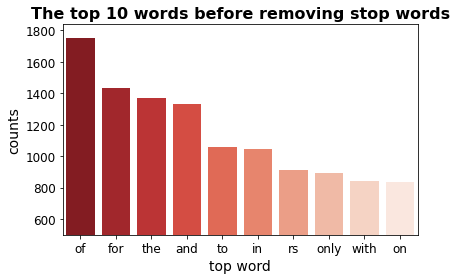

In [7]:
from nltk import FreqDist

words_flat = list(np.concatenate(tokens.values, axis=None))
frequency = FreqDist(words_flat)
top_words = sorted(frequency, key=frequency.__getitem__, reverse=True)[:10]
counts = [frequency[k] for k in top_words]
# Create the plot
sns.barplot(x=top_words, y=counts, palette='Reds_r')
plt.title("The top 10 words before removing stop words")
plt.ylim(bottom=500)
plt.xlabel("top word")
plt.ylabel("counts")
save_fig("Top_words_before_removing_stop-words")
plt.show()

All top words beyond "only" and "rs" (standing for indian rupees) are determiners, prepositions or conjunctions, and so clearly not help for finding the category of each product. Even "only" and "rs" do not realy help.  
Let's compare now with the top word obtained after removing the stop words.

As for tokenization, NLTK provides a list of common stop words for a variety of languages, such as English. This list can be found in the `stopwords` package. We will add the word "rs" to that list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

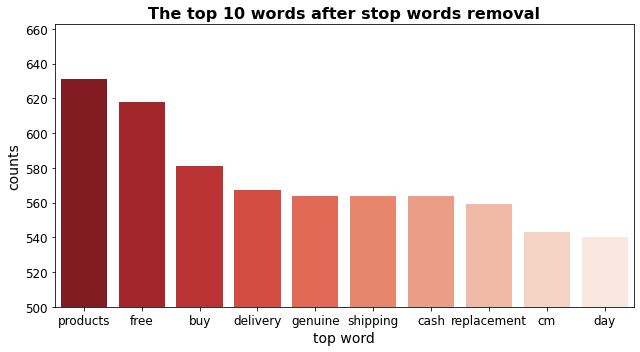

In [8]:
from nltk.corpus import stopwords

# Build the stop words corpus
stop_words = stopwords.words('english')
print(stop_words)
stop_words.append("rs")

# filter out stop words
words = tokens.copy()
for i in range(len(words)):
    words.iloc[i] = [w for w in words.iloc[i]
                     if not w in stop_words]
    
# Get word frequencies
words_flat = list(np.concatenate(words.values, axis=None))
frequency = FreqDist(words_flat)
top_words = sorted(frequency, key=frequency.__getitem__, reverse=True)[:10]
counts = [frequency[k] for k in top_words]

# Plot top words
plt.figure(figsize=(9, 5))
sns.barplot(x=top_words, y=counts, palette='Reds_r')
plt.title("The top 10 words after stop words removal")
plt.ylim(bottom=500)
plt.xlabel("top word")
plt.ylabel("counts")
save_fig("Top_words_after_removing_stop-words")
plt.show()

It is much better, we will stop here for stop words (even if we could also remove the word "cm").

#### Lemmatization

The purpose of stemming or Lemmatization is to reduce words like "studies" to a root word ("studi") or a canonical form ("study") respectively. Though it is much more easier to develop a stemmer than a lemmatizer (which requires deep linguistics knowledge to build the lemma of each word), the latter is prefered. The noise will be more reduced and so, the results provided more accurate.

In [9]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
for i in range(len(words)):
    words.iloc[i] = [lemmatizer.lemmatize(w)
                     for w in words[i]]

Creating a word cloud is a good method to visualize the corpus. It consists in randomly placing words on a canvas, with sizes proportional to their frequency.  
The `wordcloud` package enables to create it very easily.

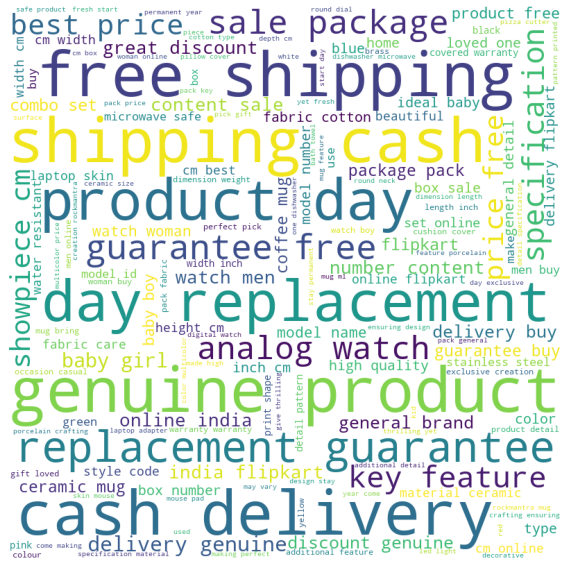

In [10]:
from wordcloud import WordCloud

# Generate the WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color='white',
                      min_font_size=10)
words_flat = list(np.concatenate(words.values, axis=None))
text = " ".join(words_flat)
wordcloud.generate(text)

# Plot the WordCloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
save_fig("WordCloud")
plt.show()

### Feature extraction

In text processing, words represent **discrete, categorical features**. These kind of features cannot be directly used by a machine learning algorithm, and must be before encoded into vectors of numbers. This process is called **feature extraction**.

#### Bag of words

One of the most popular and simplest feature extraction technique is likely the **bag-of-words** model. This model counts the occurence of each word within a document. Any information about **the order**, **grammar** or **structure** of words is discarded, only the multiplicity is kept. That is why actually, it is called a **bag** of words.

The main assumption **is that similar documents have similar contents** and so, the content may learn something about the meaning of the document to us.

The bag-of-word involves two steps:
1. Build a corpus with all the unique words present in the data provided;
2. Count the occurence of the known words for each document.

The result is a $(m, p)$ **sparse** array with $m$ the number of documents and $p$ the number of words present in the corpus.  
To get this array we can use the class `CountVectorizer` from the `sklearn.feature_extraction.text` package. This class enables **text preprocessing** in addition of **feature extraction**. However, some fancy analysis such as *stemming* or *lemmatizing* are **not included**, for this reason we will use our **prepared dataset** intead of raw data by passing `analyzer=str.split`. Note that prepared data must be stored with tokens separated by whitespace and not as a list of tokens.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Store clean data with tokens separated by whitespace
corpus = [" ".join(desc) for desc in words]

# Convert text into vectors of numbers
vect_bow = CountVectorizer(analyzer=str.split)
X_bow = vect_bow.fit_transform(corpus)
n = len(vect_bow.get_feature_names())
print("Number of unique words in the corpus: {}".format(n))

Number of unique words in the corpus: 4478


#### TF-IDF

One problem with scoring word frequency &ndash; like the Bag of Words does &ndash; is that the most frequent words in the english language will have a high score for each document. Removing the stop of words reduces the problem, but does not solve it totally.  
These frequent words may not content as much **information gain** to the model compared with some rarer and domain-specific words. One approach to fix that problem is to penalize words that are **frequent across all the documents**. the **TF-IDF** technique, standing for Term Frequency - Inverse Document Frequency, is based on this approach.

Let' see what TF and IDF mean:
- Term Frequency (TF) = Number of times a term $t$ appears in the document $/$ Total number of terms in this document
- Inverse Document Frequency (IDF) = $log($Number of documents $/$ number of documents containing the $t$ term$)$

$$\text{score(t)} = \text{tf(t)} \times log\left( \frac{n}{\text{df(t)}} \right)$$

As for the bag of words, we can use the `sklearn.feature_extraction.text` package and its `TfidfVectorizer` class to calculate the TF-IDF scores. Please note that in the sklearn library, the idf computing differs slightly from the standard textbook: a $1$ count is added to the idf to make sure terms with zero idf (when df(t) = $n$) do not be suppressed entirely.
$$\text{idf(t)}= log\left( \frac{n}{\text{df(t)}} \right) + 1$$

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into vectors of numbers with TF-IDF
vect_tfidf = TfidfVectorizer(analyzer=str.split)
X_tfidf = vect_tfidf.fit_transform(corpus)